# Safe Absorbing States

In [1]:
from dependencies.NN import *
from dependencies.LTL import *
from dependencies.Utility_funcs import *
from dependencies.maps import grid_world
from dependencies.RL_LTL import RL_LTL

from dependencies.csrl.mdp import GridMDP
from dependencies.csrl.oa import OmegaAutomaton
from dependencies.csrl import ControlSynthesis
import numpy as np

from matplotlib import pyplot as plt

2024-03-13 17:15:55.897584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of Omega-automaton states (including the trap state): 4


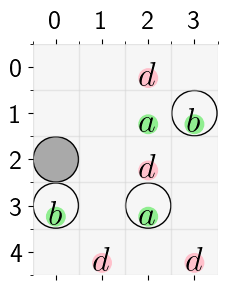

In [2]:
gw = grid_world(name='safe_absorbing', plot=True, p=1)

In [4]:
model = build_model(gw.ch_states[(0,0,0,0)].shape, gw.csrl.shape[-1])
# model.load_weights(f'outputs/models/safe_absorbing_p{gw.p}')
gw = grid_world(name='safe_absorbing', plot=False, p=1)
env = RL_LTL(gw, model)

env.train(20, smart_start=True)
env.get_policy(1, reset_tables=False)

with open(f'outputs/Ours/safe_absorbing/safe_absorbing_p{gw.p}.txt', 'w') as f:
    f.write('succ_rate:\n')
    f.write(', '.join(str(i) for i in env.policy_succ_rate))

model.save_weights(f'outputs/models/safe_absorbing_p{gw.p}')
np.save(f'outputs/Ours/sequential_delivery_p{gw.p}', env.policy)

Number of Omega-automaton states (including the trap state): 4
##########################
C: 0.5 | tow: 0.2
0 ) MCTS conf: 0.88 , det: 0.99 | s: 13 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('b',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 220 / 500 = 0.44
1 ) MCTS conf: 0.94 , det: 0.96 | s: 3 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('b',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 275 / 500 = 0.55
2 ) MCTS conf: 0.98 , det: 0.98 | s: 1 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 404 / 500 = 0.808
3 ) MCTS conf: 0.94 , det: 0.93 | s: 0 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 500 / 500 = 1.0
Train wins: 4 / 3
0 ) MCTS conf: 1.0 , det: 1.0 | s: 1 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',)]
Test wins: 1 / 1
Running 100

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 4, 4)]    0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 5, 4, 32)     544         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 160)          0           ['conv2d_3[0][0]']               
                                                                                            

In [5]:
model(ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [6]:
# model.load_weights(f'first_case_{p}')

In [44]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10
NN_value_active = False

search_depth = 100
MCTS_samples = 100

num_training_epochs =  10
num_test_epochs = 200
training = True
epochs = 10
C = 1
tow = 0.1
T = [25]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []
best_val_len = {}
for s in csrl.states(): best_val_len[s] = (0.001, 99999)

# os.remove("outputs/Log_run.txt")
for i in T:
    idx += 1
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=C, tow=tow, n_samples=MCTS_samples, visited=visited_train,
                start=None, search_depth=search_depth, verbose=0, T=i, K=K, NN_value_active=NN_value_active, run_num=epoch, ltl_f_rew=False, reachability=True,
                best_val_len = best_val_len)
        
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0:
            train_wins+=1
            NN_value_active = True

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=1, tow=0.1, n_samples=MCTS_samples, visited=visited_test,
                start=None, search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True, reachability=True, best_val_len = best_val_len)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]
Q1, N1, W1, P1 = Q, N, W, P
# u, d, r, l

0 ) MCTS conf: 0.48 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [3, 3, 3, 3, 3, 3, 3, 7, 7]
1 ) MCTS conf: 0.34 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [4, 5, 6, 6]
2 ) MCTS conf: 0.85 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [5, 6, 6]
3 ) MCTS conf: 0.84 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [5, 6, 6]
4 ) MCTS conf: 0.94 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [5, 6, 6]
5 ) MCTS conf: 0.63 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [18, 14, 14]
6 ) MCTS conf: 0.91 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [4, 5, 6, 6]
7 ) MCTS conf: 0.75 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [1, 5, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 5, 6, 6]
8 ) MCTS conf: 0.85 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [3, 7, 7]
9 ) MCTS conf: 0.91 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [4, 5, 6, 6]
Train wins: 10 / 10
None ) MCTS conf: 0.55 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [13, 14, 14]
None ) MCTS conf: 0.59 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [3, 2]
None ) MCTS con

In [45]:
Q1, N1, W1, P1 = Q, N, W, P

In [10]:
Q.shape

(1, 4, 5, 4, 8)

In [11]:
# u, d, r, l
state = (0, 0, 0, 1)
print(Q[state])
print(N[state])
csrl.transition_probs[state][0]
p

[-0.5         0.78942014 -0.15384615  0.61561396  0.         -0.19924885
 -0.10163357  0.        ]
[2.000e+00 5.898e+03 1.300e+01 5.370e+02 0.000e+00 4.000e+00 3.000e+00
 0.000e+00]


0.8

In [24]:
model.save_weights(filepath=f'models/safe_absorbing_{p}')

[93.0, 95.0, 92.0, 97.0, 91.0, 95.0, 95.0, 98.0]

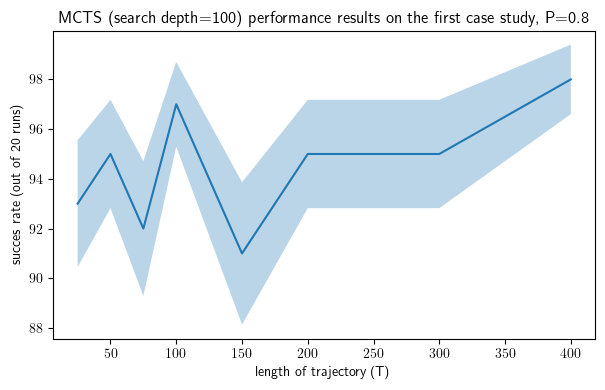

In [25]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 20 runs)")
plt.title("MCTS (search depth="+str(search_depth)+") performance results on the first case study, P="+str(p))
success_rates

In [16]:
Q = np.load(f'outputs/CSRL/Q1_{p}.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'Q1_0.8.npy'

In [7]:
Q =csrl.q_learning(T=100,K=100000)
np.save(f'outputs/CSRL/Q1_{p}', Q)

In [46]:
policy1=np.argmax(Q,axis=4)
value1=np.max(Q,axis=4)

In [47]:
policy2=np.argmax(N1,axis=4)
value2=np.max(N1,axis=4)

In [38]:
policy2

array([[[[2, 1, 0, 1],
         [2, 2, 5, 6],
         [0, 0, 0, 0],
         [0, 2, 5, 3],
         [0, 0, 0, 0]],

        [[2, 2, 0, 0],
         [2, 2, 0, 2],
         [0, 1, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 1, 0]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[2, 2, 0, 2],
         [1, 2, 2, 2],
         [0, 3, 0, 2],
         [1, 2, 2, 0],
         [0, 0, 0, 0]]]])

In [39]:
policy1.shape, policy2.shape

((1, 4, 5, 4), (1, 4, 5, 4))

In [48]:
episodes, rew = run_Q_test(csrl, policy2, LTL_formula, predicates, start=None, T=100, runs=1000, verbose=0, reachability=True)

Running 1000 simulations with 100 time-steps...
Test finished with:
	success rate: 872 / 1000 = 0.872


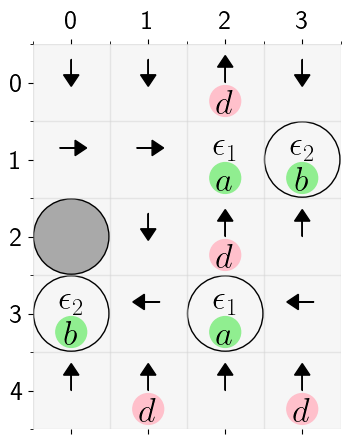

In [49]:
grid_mdp.plot(policy=policy2[0, 0])

In [37]:
np.sum([any([i>0 for i in [csrl.reward[x] for x in episode]]) for episode in episodes])/200

0.73

In [13]:
T = [25, 50, 75, 100, 150, 200, 300, 400]

In [31]:
rewards_mean = []
rewards_std = []
n_runs = 500

for i in T:
    episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=i, start=None, runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 500 simulations with 25 time-steps...
Test finished with:
	success rate: 252 / 500 = 0.504
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 274 / 500 = 0.548
Running 500 simulations with 75 time-steps...
Test finished with:
	success rate: 310 / 500 = 0.62
Running 500 simulations with 100 time-steps...
Test finished with:
	success rate: 315 / 500 = 0.63
Running 500 simulations with 150 time-steps...
Test finished with:
	success rate: 383 / 500 = 0.766
Running 500 simulations with 200 time-steps...
Test finished with:
	success rate: 395 / 500 = 0.79
Running 500 simulations with 300 time-steps...
Test finished with:
	success rate: 438 / 500 = 0.876
Running 500 simulations with 400 time-steps...
Test finished with:
	success rate: 451 / 500 = 0.902


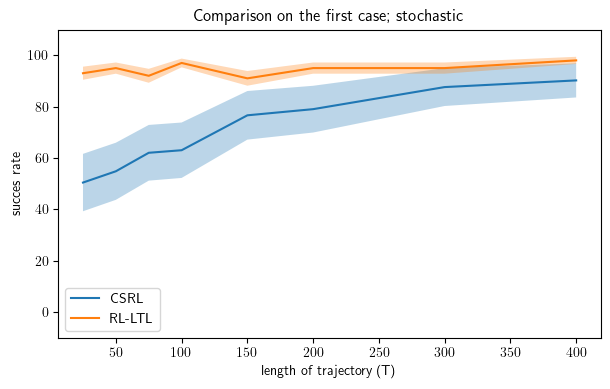

In [32]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the first case; stochastic")
# plt.title("Comparison on the first case; deterministic")
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="RL-LTL")
plt.legend()
plt.savefig(f"res_400/C1_P{p}.pdf")

Text(0.5, 1.0, 'CSRL performance results on the first case study, P=0.8')

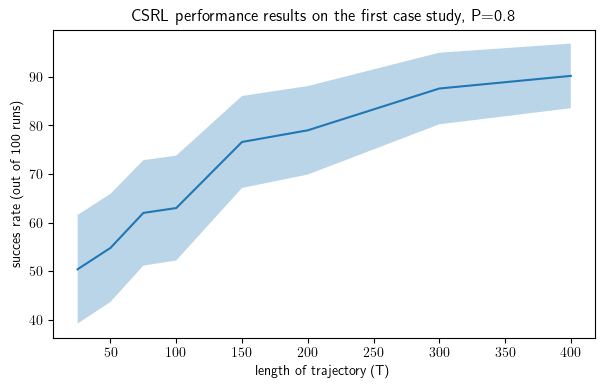

In [33]:
plt.figure(figsize=(7,4))
plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 100 runs)")
plt.title("CSRL performance results on the first case study, P="+str(p))